# OPTIMAL CUTTING LAYOUTS FOR METAL PARTS MANUFACTURING

## ABOUT THE USE CASE

For producing metal parts, the Manufacturing Industry uses lasers to cut pre-defined geometric shapes on metal sheets.

[https://mediapool.trumpf.com/media/?mediaId=DA6CCC82-BB16-48A3-802867B4BDC81EBE](https://mediapool.trumpf.com/media/?mediaId=DA6CCC82-BB16-48A3-802867B4BDC81EBE)

*Source: TRUMPF Group*

The goal is to find a *layout* (see image below) specifying the position and orientation of the shapes that will cut all the shapes needed using the **smallest possible metal sheet**. This allows not only to **reduce material costs** for the producer but also to **reduce the consumption of natural resources and industrial waste**.

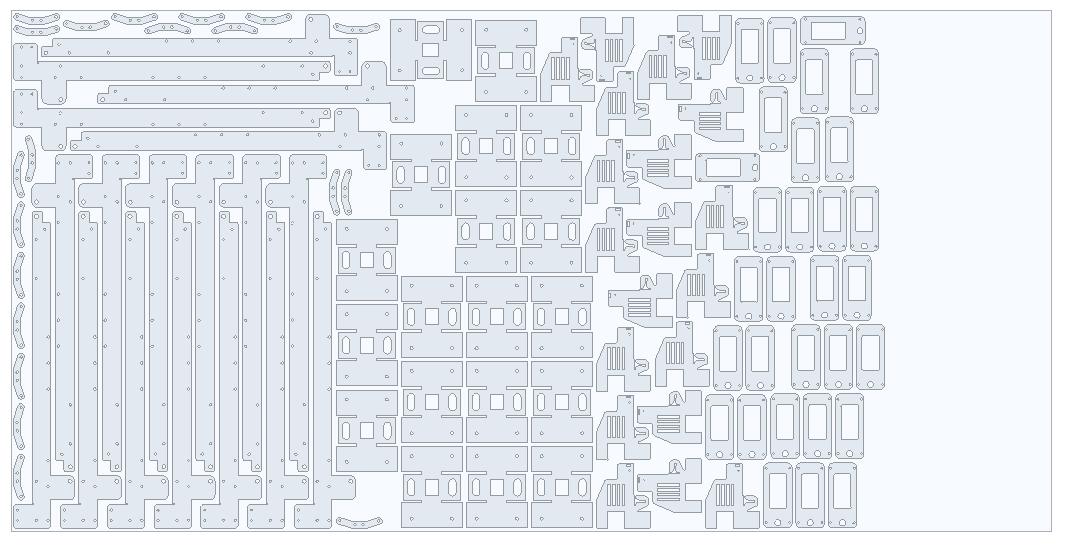

In [15]:
from IPython.display import Image
Image(filename='illustration-Schachtelung 2.PNG')

*Source: TRUMPF Group*

The problem is not specific to the manufacturing of parts made of metal, but is the same with other materials such as fabric, paper, carton, plastic, glass and ceramics.

## FORMAL PROBLEM STATEMENT

The problem can be interpreted in several ways, but we will consider one important variant of the problem known as the **2D irregular strip packing problem**. In this case, we assume that:
- there are $N$ pieces with polygonal shapes (regular or irregular polygons, convex or not),
- there is only one sheet called "strip", with rectangular shape, fixed height $H$ and variable length $L$,
- all pieces need to be placed into the strip without overlapping,
- the pieces can be continuously placed anywhere in the strip and can be rotated, but only a fixed number of rotation angles (e.g. multiples of $45$ degrees) are allowed, and
- the length $L$ of the strip must be minimized (material/waste minimization).


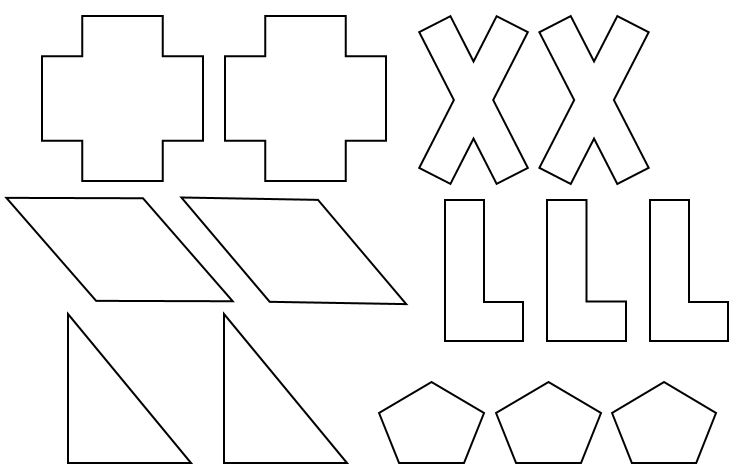

In [26]:
Image(filename='illustration-set-of-pieces.JPG')

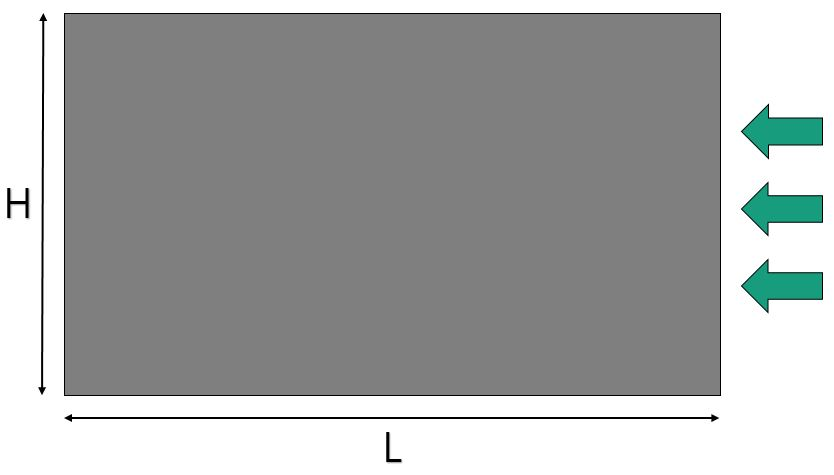

In [27]:
Image(filename='illustration-strip.JPG')

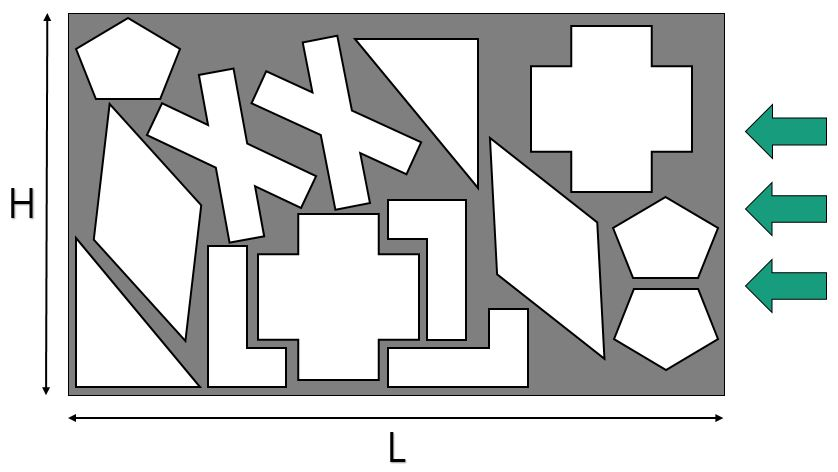

In [28]:
Image(filename='illustration-layout.JPG')

## IMPORT PYTHON MODULES

In [4]:
from QUANTUM_PACKER import QUANTUM_PACKER
from qiskit import Aer
from qiskit import IBMQ
from PACKING_PROBLEM_DATA_LOADER import PACKING_PROBLEM_DATA_LOADER

## IMPORT ONE OF THE PREDEFINED PROBLEM INSTANCES

Choose an instance from “PUZZLE1”, “PUZZLE2”, “PUZZLE3” or the standard benchmarks “SHAPES1”, “SHAPES2”, “SHIRTS”, “TROUSERS”, “SWIM” (Oliveira et al., 2000). The variable *pieces* here-after is a list containing the polygons to pack. Each polygon is represented by a list of vertex coordinates $(x,y)$. The height of the strip is defined by the variable $H$.

In [5]:
problem_instance = "PUZZLE3"
packing_problem_data = PACKING_PROBLEM_DATA_LOADER(problem_instance)
pieces = packing_problem_data.pieces
H = packing_problem_data.height
print("For " + problem_instance + ", the strip's height is fixed to H=" + str(H) + ".")

For PUZZLE3, the strip's height is fixed to H=1200.


## DEFINE A QUANTUM BACKEND FOR EXECUTING QUANTUM ALGORITHMS

Leave the fields API_TOKEN_DE and API_URL_DE blank if you do not have access to the IBM Quantum System One located in Ehningen, Germany. If you have access to another backend, you can use it by adapting the code specifying the provider and backend's name. By default, the following code will use the qasm simulator and run it on your PC.

In [6]:
API_TOKEN_DE = ''
API_URL_DE = ''
if API_TOKEN_DE == '' and API_URL_DE == '':
    solver_backend = Aer.get_backend('qasm_simulator')
else:
    IBMQ.enable_account(API_TOKEN_DE, API_URL_DE)
    provider = IBMQ.get_provider(hub='fraunhofer-de', group='fhg-all')
    solver_backend = provider.get_backend('ibmq_ehningen')

## DEFINE ADDITIONALLY A QUANTUM SIMULATOR

This will be required for optimizing the QAOA or QAOA+ parameter vectors $\beta$ and $\gamma$. Specify also the number of qubits available.

In [7]:
num_qubits = 16
backend = Aer.get_backend('qasm_simulator')

## CREATE A QUANTUM_PACKER FOR SOLVING THE PROBLEM INSTANCE

Choose the number of angles of rotations allowed for the pieces, e.g. 0, 2 (0 and 180 degrees), 4 (multiples of 90 degrees), 8 (multiples of 45 degrees) or 16. Specify the number of randomly generated partitions (groups of geometrically compatible pieces), typically between 50 and 500. Set the distance threshold between 0.1 and 0.5, so as to impose an upper limit on the geometrical incompatibility between the pieces in a group. The variable tsp_solver represents the algorithm used to solve the Traveling Salesman Problem (TSP). This can be 'BF' (brute force), 'QAOA' (Quantum Approximate Optimization Algorithm) by (Farhi et al., 2014) or 'QAOA+' (Quantum Alternating Operator Ansatz) by (Hadfield et al., 2019). The maximum cluster size is fixed to $4$ for QAOA and QAOA+, which means that we cannot solve TSP instances with more than 4 cities, since we have only 16 qubits (for the simulator) and solving the TSP with $n$ cities requires solving a QUBO with $n^2$ binary variables or qubits. If you wish to use brute force to solve TSPs, you may increase the max_cluster_size up to $10$ cities.

In [8]:
n_rotations = 8
n_partitions = 50
tsp_solver = 'QAOA'
distance_threshold = 0.25
max_cluster_size = 4
quantum_packer = QUANTUM_PACKER(problem_instance, H, pieces, n_rotations,
                                tsp_solver, distance_threshold, max_cluster_size, n_partitions,
                                num_qubits, backend, solver_backend)

## SHOW THE SET OF PIECES TO PACK

In [ ]:
%config InlineBackend.figure_format = 'retina'

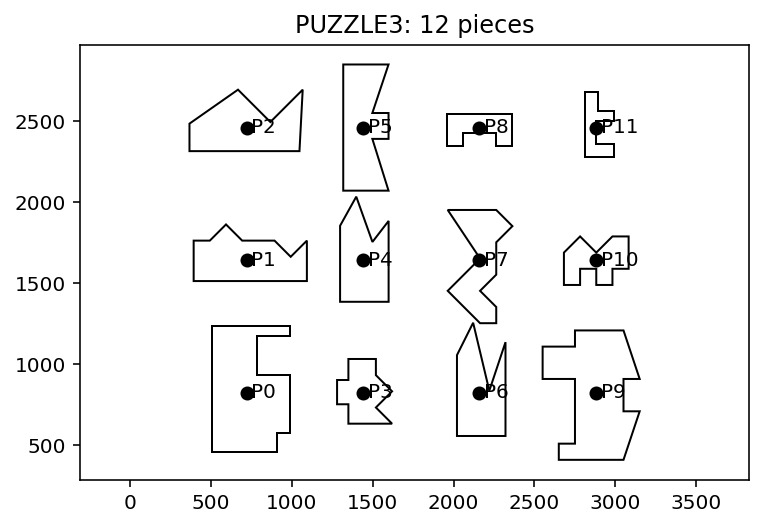

In [9]:
quantum_packer.show_pieces()

## A QUANTUM-CLASSICAL HEURISTIC FOR SOLVING THE PACKING PROBLEM

The main algorithmic steps are the following ones.

### EVALUATE THE GEOMETRICAL COMPATIBILITY BETWEEN PIECES

For each pair of pieces, we find the spatial arrangement that minimizes the wasted area between them, relative to the area of their convex hull. The minimal fraction of waste is interpreted as their *geometrical incompatibility* (gi). Considering all pairs of pieces of PUZZLE3, we get a matrix $GI=((gi(P_i,P_j)))$:

$$ GI = \left[ \begin{array}{rrrrrrrr}
0.148 & 0.168 & 0.171 & 0.178 & 0.170 & 0.151 & 0.183 & 0.236 & 0.147 & 0.073 & 0.148 & 0.180 \\
0.168 & 0.072 & 0.172 & 0.157 & 0.176 & 0.148 & 0.205 & 0.142 & 0.163 & 0.205 & 0.210 & 0.178 \\
0.171 & 0.172 & 0.098 & 0.151 & 0.165 & 0.181 & 0.208 & 0.109 & 0.163 & 0.209 & 0.147 & 0.162 \\
0.178 & 0.157 & 0.151 & 0.203 & 0.189 & 0.221 & 0.230 & 0.261 & 0.130 & 0.200 & 0.136 & 0.225 \\
0.170 & 0.176 & 0.165 & 0.189 & 0.085 & 0.151 & 0.129 & 0.230 & 0.200 & 0.179 & 0.184 & 0.195 \\
0.151 & 0.148 & 0.181 & 0.221 & 0.151 & 0.143 & 0.182 & 0.278 & 0.169 & 0.150 & 0.206 & 0.225 \\
0.183 & 0.205 & 0.208 & 0.230 & 0.129 & 0.182 & 0.091 & 0.281 & 0.245 & 0.214 & 0.228 & 0.261 \\
0.236 & 0.142 & 0.109 & 0.261 & 0.230 & 0.278 & 0.281 & 0.272 & 0.287 & 0.273 & 0.272 & 0.313 \\
0.147 & 0.163 & 0.163 & 0.130 & 0.200 & 0.169 & 0.245 & 0.287 & 0.146 & 0.214 & 0.240 & 0.212 \\
0.073 & 0.205 & 0.209 & 0.200 & 0.179 & 0.150 & 0.214 & 0.273 & 0.214 & 0.149 & 0.203 & 0.225 \\
0.148 & 0.210 & 0.147 & 0.136 & 0.184 & 0.206 & 0.228 & 0.272 & 0.240 & 0.203 & 0.231 & 0.131 \\
0.180 & 0.178 & 0.162 & 0.225 & 0.195 & 0.225 & 0.261 & 0.313 & 0.212 & 0.225 & 0.131 & 0.154 \\
\end{array}\right] $$

### GENERATE GROUPS OF COMPATIBLE PIECES (CLUSTERING)

Two pieces are "compatible" when their geometrical incompatibility is below a "distance threshold" of for instance 0.25. Using a stochastic clustering algorithm, we generate many groups of pieces, such that in each group, every piece is compatible with at least one other piece. Here are some examples obtained for PUZZLE3 containing up to $4$ pieces.
$$ \{P_4, P_6\}, \{P_5, P_9\}, \{ P_0, P_5, P_9\}, \{P_1, P_2, P_7\}, \{P_0, P_1, P_2, P_7\}, \{ P_3, P_8, P_{10}, P_{11}\}, \dotsc$$

### ORDER THE PIECES IN EACH CLUSTER TO FORM A "SHORT" SEQUENCE [NP-HARD]

The pieces in each group are given a sequential order. We want to find a "short" sequence $i_1, \dotsc, i_n$ for each cluster of size $n$, i.e. a sequence with minimum total geometric incompatibility, calculated by summing up the incompatibility between all pairs of successive pieces in the cluster:

$$ \sum_{k=1}^{n-1} \mathrm{gi}(P_{i_k}, P_{i_{k+1}})$$

By treating the geometrical incompatibility between two pieces as the "distance" between two "cities", this problem becomes equivalent to the Traveling Salesman Problem (TSP): Given a set of $n$ cities $1, \dotsc, n$, find a route $i_1, \dotsc, i_n$ for visiting each city exactly once with minimum total travel distance $$\sum_{k=1}^{n-1} \mathrm{d}(i_k, i_{k+1})$$

The TSP can be formulated as a Quadratic Unconstrained Optimization Problem (Lucas, 2014):
- let $x_{i,p} \in \{0,1\}$ be $1$ if the path goes through city $i$ at step $p$
- the path goes through $n$ cities iff $\forall p \in \{ 1, \dotsc, n\}: \sum_{i=1}^n x_{i,p} = 1$
- each city is visited once iff $\forall i \in \{ 1, \dotsc, n\}: \sum_{p=1}^n x_{i,p} = 1$
- the distance to be minimized is $D(x) = \sum_{i=1}^n \sum_{j=1}^n d_{i,j} \sum_{p=1}^{n-1} x_{i,p}x_{j,p+1}$
- the TSP is equivalent to minimizing
    $$ C(x) = \sum_{i=1}^n \sum_{j=1}^n d_{i,j} \sum_{p=1}^{n-1} x_{i,p}x_{j,p+1} + A \sum_{p=1}^n \left( 1 - \sum_{i=1}^n x_{i,p} \right)^2 + A \sum_{i=1}^n \left( 1 - \sum_{p=1}^n x_{i,p} \right)^2 $$
as long as the penalty $A$ is large enough ($A > \max\{d_{i,j}\}$). The QUBO can then be solved by Quantum Computing, for instance on a gate-based quantum computer using the Quantum Approximate Optimization Algorithm (QAOA) or the Quantum Alternating Operator Ansatz (QAOA+), or by using a quantum annealer. Note that exact solutions can also be obtain classically by brute force search (BF) for up to $12$ cities. Here are some examples of short sequences obtained with PUZZLE3:
- cluster $\{ 4, 6\} \quad \rightarrow \quad$ sequence $[4, 6]$
- cluster $\{ 5, 9\} \quad \rightarrow \quad$ sequence $[5, 9]$
- cluster $\{ 0, 5, 9\} \quad \rightarrow \quad$ sequence $[0, 9, 5]$
- cluster $\{ 1, 2, 7\} \quad \rightarrow \quad$ sequence $[2, 7, 1]$
- cluster $\{ 0, 1, 2, 7\} \quad \rightarrow \quad$ sequence $[2, 7, 1, 0]$
- cluster $\{ 3, 8, 10, 11\} \quad \rightarrow \quad$ sequence $[8, 3, 10, 11]$

### USE THE SHORT SEQUENCES TO PACK CLUSTER PIECES INSIDE COMPACT RECTANGLES

The groups of pieces are then spatially arranged by taking the pieces in the order of the short sequence and aggregating them one by one without overlapping so as to keep the bounding box of the aggregate as small as possible in each step ("greedy approach"). We obtain an arrangement of each group of pieces and a small bounding box or "compact rectangle".

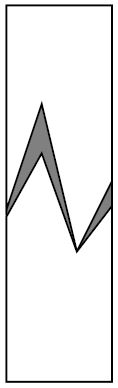

In [32]:
Image(filename='illustration-R{4,6}.JPG')

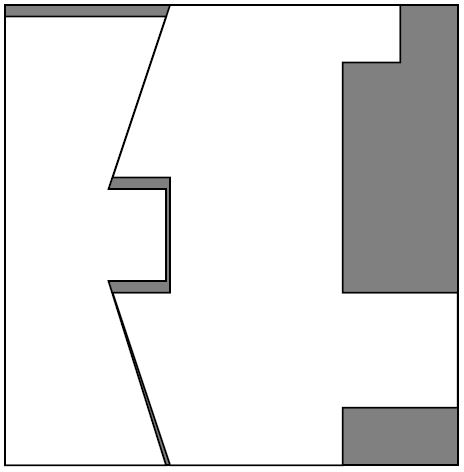

In [34]:
Image(filename='illustration-R{5,9}.JPG')

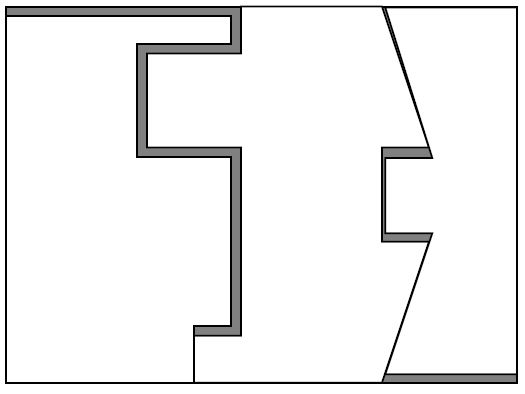

In [35]:
Image(filename='illustration-R{0,5,9}.JPG')

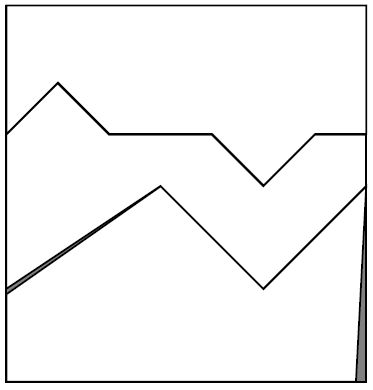

In [36]:
Image(filename='illustration-R{1,2,7}.JPG')

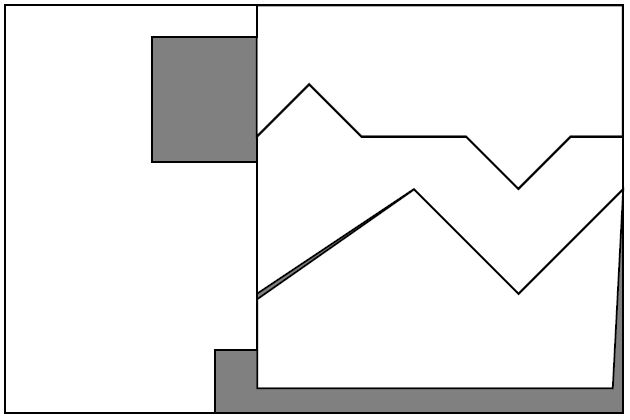

In [38]:
Image(filename='illustration-R{0,1,2,7}.JPG')

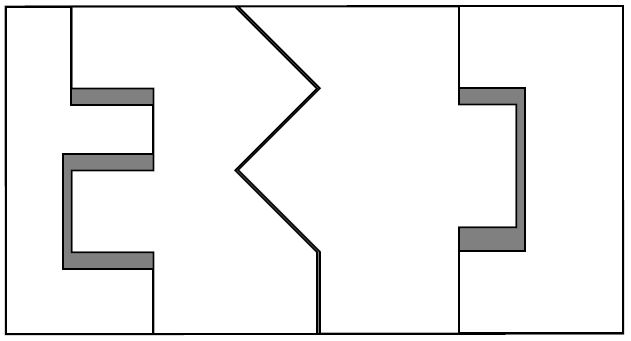

In [39]:
Image(filename='illustration-R{3,8,10,11}.JPG')

### GENERATE PARTITIONS OF THE SET OF PIECES

Generate randomly partitions, using the best rectangular arrangements, i.e. the rectangles that are the most compact.

$$ \{P_0, P_1, P_2, P_7\}, \{P_3, P_8, P_{10}, P_{11}\}, \{P_4, P_6\}, \{P_5, P_9\}$$
$$ \{P_0, P_5, P_9\}, \{P_1, P_2, P_7\}, \{P_3, P_8, P_{10}, P_{11}\}, \{P_4, P_6\}$$

### PACK THE RECTANGLES INTO THE STRIP [NP-HARD]

The packing problem is thus reduced for each partition of the set of $N$ pieces to the problem of packing only rectangles in the strip. The **rectangle packing problem** can be solved using an efficient classical algorithm called MAXRECTS (Jylänki, 2010). Note that this sub-problem is NP-hard and that it can also be formulated as a QUBO and then solved by Quantum Computing (Terada et al., 2018). Here is an example corresponding to the partition $\{P_0, P_1, P_2, P_7\}, \{P_3, P_8, P_{10}, P_{11}\}, \{P_4, P_6\}, \{P_5, P_9\}$:

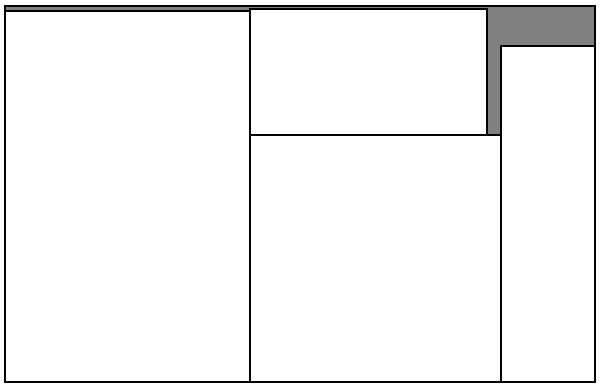

In [41]:
Image(filename='illustration-rectangle-layout-PUZZLE3.JPG')

### LOCAL [NP-HARD] AND GLOBAL OPTIMIZATION OF THE STRIP LENGTH

For each partition, we use the solution of the rectangle packer to get an initial layout for the $N$ pieces. This layout is then improved by minimizing the length of the strip $L$ with respect to the coordinates of the pieces (orientations remain fixed). This step is an NP-hard problem. Afterwards, we improve again the layout by global optimization. Here, the right-most pieces in the strip are repeatedly shifted whenever possible to the left-most unoccupied space.

### RETURN THE BEST LAYOUT

After examining the layouts obtained for all the partitions generated, we return as solution the one with the shortest length $L$. The optimal length for PUZZLE3 is $L=1880.44$ which yields a waste of $14.94\%$. This can be achieved for instance with the partition $\{P_0, P_1, P_2, P_7\}, \{P_3, P_8, P_{10}, P_{11}\}, \{P_4, P_6\}, \{P_5, P_9\}$ (shown here-below) or with $\{P_0, P_5, P_9\}, \{P_1, P_2, P_7\}, \{P_3, P_8, P_{10}, P_{11}\}, \{P_4, P_6\}$.

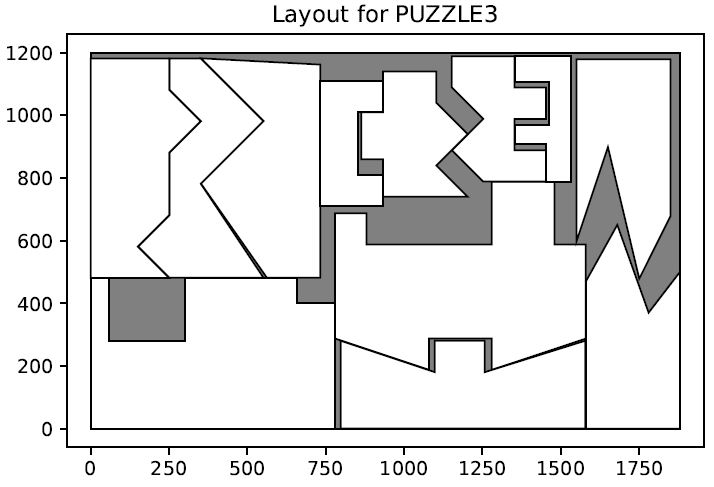

In [42]:
Image(filename='illustration-layout-PUZZLE3-0127-381011-46-59.JPG')

## SOLVE THE PACKING PROBLEM AND SHOW THE BEST LAYOUT FOUND:

The distance matrix and nofit functions have already been pre-computed and will be directly loaded
[[110332.9  99391.3 104405.9  88739.6  95897.1  89548.9 105074.1 141070.4
   65864.4  49802.6  69743.3  79106.9]
 [ 99391.3  27301.8  75994.1  50006.6  69341.8  63188.8  84261.1  51924.6
   46509.3 127987.4  69289.5  47487.5]
 [104405.9  75994.1  41237.7  50557.5  67522.6  83519.1  90059.7  40373.4
   49663.4 134586.9  47421.4  45566.4]
 [ 88739.6  50006.6  50557.5  47631.1  56754.8  79854.5  73505.2  82376.9
   23610.4 103540.   28144.   40057.7]
 [ 95897.1  69341.8  67522.6  56754.8  27838.9  60134.2  44784.5  86602.9
   53706.2 102904.4  53073.4  47315.1]
 [ 89548.9  63188.8  83519.1  79854.5  60134.2  62295.9  75743.3 125825.1
   50989.5  89455.6  70637.4  67416.2]
 [105074.1  84261.1  90059.7  73505.2  44784.5  75743.3  30438.6 114271.5
   70000.3 128547.   69936.9  69327.5]
 [141070.4  51924.6  40373.4  82376.9  86602.9 125825.1 114271.5 104631.4
   82237.3 172385.2  84117.9  84160.

C:\Users\pam\PycharmProjects\QuantumPacker\TSP_QAOA_SOLVER.py:462: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(1)


TSP problem #1 for set of pieces {0} REF:0
TSP problem #2 for set of pieces {1} REF:1
TSP problem #3 for set of pieces {2} REF:2
TSP problem #4 for set of pieces {3} REF:3
TSP problem #5 for set of pieces {4} REF:4
TSP problem #6 for set of pieces {5} REF:5
TSP problem #7 for set of pieces {6} REF:6
TSP problem #8 for set of pieces {7} REF:7
TSP problem #9 for set of pieces {8} REF:8
TSP problem #10 for set of pieces {9} REF:9
TSP problem #11 for set of pieces {10} REF:10
TSP problem #12 for set of pieces {11} REF:11
TSP problem #13 for set of pieces {8,10} REF:8-10
TSP problem #14 for set of pieces {5,8} REF:5-8
TSP problem #15 for set of pieces {3,9} REF:3-9
TSP problem #16 for set of pieces {1,11} REF:1-11
TSP problem #17 for set of pieces {1,7} REF:1-7
TSP problem #18 for set of pieces {5,11} REF:5-11
TSP problem #19 for set of pieces {4,5} REF:4-5
TSP problem #20 for set of pieces {4,6} REF:4-6
TSP problem #21 for set of pieces {5,10} REF:5-10
TSP problem #22 for set of pieces {0,

C:\Users\pam\PycharmProjects\QuantumPacker\QUANTUM_PACKER.py:515: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  list_of_polygons = list(p1) + [p2]
C:\Users\pam\PycharmProjects\QuantumPacker\QUANTUM_PACKER.py:515: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  list_of_polygons = list(p1) + [p2]
C:\Users\pam\PycharmProjects\QuantumPacker\QUANTUM_PACKER.py:162: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  return self.is_intersection(list(shape1), shape2)
C:\Users\pam\PycharmProjects\QuantumPacker\QUANTUM_

Showing the result of greedy packer for:  [10, 5, 3]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

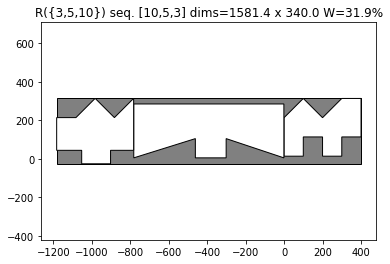

Packing pieces 10-11
Packing pieces 0-7
Packing pieces 0-2-3-9
Packing pieces 2-5-7
Packing pieces 5-8-9
Packing pieces 5-6-8
Packing pieces 0-10
Packing pieces 1-2-7
Packing pieces 5-9
Packing pieces 5-6-8-10
Packing pieces 2-3-9
Packing pieces 2-8-10
Packing pieces 2-5
Packing pieces 3-5-9
Packing pieces 2-4-9
Generating partitions:
     [[0, 5, 9], [1, 2, 7], [3, 8, 10, 11], [4, 6]]
     [[0, 9], [1, 2, 7], [3, 8, 10, 11], [4, 6], [5]]
     [[0, 5, 9], [1, 2, 7], [3, 8, 10, 11], [4], [6]]
     [[0, 9], [1, 2, 7], [3, 8, 10, 11], [4, 5, 6]]
     [[0, 5, 9], [1, 7], [2], [3, 8, 10, 11], [4, 6]]
     [[0, 5, 9], [1, 2, 6, 7], [3, 8, 10, 11], [4]]
     [[0, 5, 9], [1, 2, 7], [3, 10, 11], [4, 6], [8]]
     [[0, 5, 9], [1, 2, 7], [3, 8, 10], [4, 6], [11]]
     [[0, 5, 9], [1, 2], [3, 8, 10], [4, 6], [7], [11]]
     [[0], [1, 2, 7], [3, 8, 10, 11], [4, 6], [5], [9]]
     [[0, 1, 2, 7], [3, 8, 10, 11], [4, 6], [5], [9]]
     [[0, 1, 2, 7], [3, 8, 10, 11], [4, 6], [5, 9]]
     [[0, 5, 9], [1

C:\Users\pam\PycharmProjects\QuantumPacker\QUANTUM_PACKER.py:787: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  layout += list(packed_pieces)
C:\Users\pam\PycharmProjects\QuantumPacker\QUANTUM_PACKER.py:787: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  layout += list(packed_pieces)


            running local optimization...
            the optimized layout fits the container height
IMPROVED CONTAINER LENGTH: 2202.449465127431
{'0-5-9': (0, 0, 800, 1088, 0), '1-2-7': (800, 0, 701, 732, 0), '4-6': (1501, 0, 301, 1071, 0), '3-8-10-11': (1802, 0, 402, 756, 0)}
        packing rectangles in strip of height H=1320.0
RectPack: Required height = 1088, required length = 2204
            found a layout that fits in that bin
            running local optimization...
            the optimized layout fits the container height
            the container length has not been improved
        packing rectangles in strip of height H=1440.0
RectPack: Required height = 1389, required length = 1827
            found a layout that fits in that bin
            running local optimization...
        packing rectangles in strip of height H=1200.0
RectPack: Required height = 1088, required length = 2204
            found a layout that fits in that bin
            running local optimization..

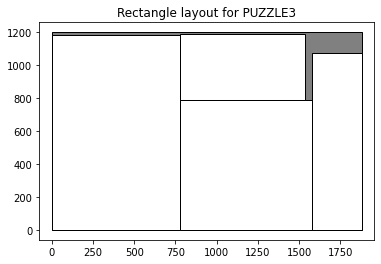

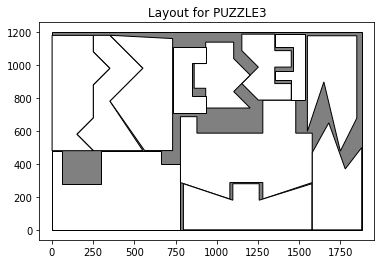

In [14]:
# solve the irregular packing problem
layout, L_min, partition_name, rectangle_layout = quantum_packer.solve()

# show the solution
if layout == None:
    print('WARNING: NO SOLUTION FOUND FOR 2D IRREGULAR STRIP PACKING PROBLEM ' + problem_instance)
else:
    rectangle_layout_title = 'Rectangle layout for ' + problem_instance
    quantum_packer.show_layout(rectangle_layout, rectangle_layout_title, board_dimensions=(L_min, H))
    title = 'Layout for ' + problem_instance
    quantum_packer.show_layout(layout, title, board_dimensions=(L_min, H))

## REFERENCES

Farhi, Goldstone & Gutmann (2014). **A quantum approximate optimization algorithm**. *arXiv preprint arXiv:1411.4028*.

Hadfield, Wang, O’gorman, Rieffel, Venturelli & Biswas (2019). **From the quantum approximate optimization algorithm to a quantum alternating operator ansatz**. *Algorithms, 12(2), 34*.

Jylänki (2010). **A thousand ways to pack the bin-a practical approach to two-dimensional rectangle bin packing**. *retrived from http://clb. demon. fi/files/RectangleBinPack. pdf*.

Lucas (2014). **Ising formulations of many NP problems**. *Frontiers in physics, 2, 5*.

Oliveira, Gomes, & Ferreira (2000). **TOPOS–A new constructive algorithm for nesting problems**. *OR-Spektrum, 22, 263-284*.

Terada, Oku, Kanamaru, Tanaka, Hayashi, Yamaoka & Togawa. (2018, April). **An Ising model mapping to solve rectangle packing problem**. *In 2018 International Symposium on VLSI Design, Automation and Test (VLSI-DAT) (pp. 1-4). IEEE*.

**Copyright 2023 Paul-Amaury Matt, Fraunhofer IPA**

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at:

[http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.